### Imports ###

In [1]:
import os
import sys
import time
from PIL import Image # type: ignore
import albumentations as A # type: ignore
from albumentations.pytorch import ToTensorV2 # type: ignore
import numpy as np # type: ignore
from tqdm import tqdm # type: ignore
from torch.utils.data import DataLoader # type: ignore
import torch # type: ignore
import matplotlib.pyplot as plt # type: ignore
import random
from collections import Counter


### Load and prepare dataset ###

##### Dataset #####

In [2]:
class Dataset:
    def __init__(self, path, transform, classes='all', synthetic_over_sampling=None):
        self.path = path
        self.transform = transform
        self.labels = []
        self.images = []
        if classes == 'all':
            self.classEncoding = {'dog': 0, 'cat': 1, 'horse': 2, 'elephant': 3, 'butterfly': 4, 'chicken': 5, 'cow': 6, 'spider': 7, 'squirrel': 8, 'sheep': 9}
        else:
            self.classEncoding = {}
            for i, c in enumerate(classes):
                self.classEncoding[c] = i
        self.load_data()

        self.syntetic_samples = None
        if synthetic_over_sampling is not None:
            self.synthetic_transform = synthetic_over_sampling
            self.SyntheticOversampling()
    
    def load_data(self):
        for filename in tqdm(os.listdir(self.path)):
            if filename.split('_')[0] not in self.classEncoding:
                continue
            
            self.labels.append(self.classEncoding[filename.split('_')[0]])
            img_name = os.path.join(self.path, filename)
            self.images.append(img_name)

    def __getitem__(self, idx):
        if self.syntetic_samples is not None:
            if self.syntetic_samples[idx] == 1:
                img = Image.open(self.images[idx])
                img = self.synthetic_transform(image=np.array(img))['image']
                label = self.labels[idx]
                return img, label
            else:
                img = Image.open(self.images[idx])
                img = self.transform(image=np.array(img))['image']
                label = self.labels[idx]
                return img, label
        else:
            img = Image.open(self.images[idx])
            img = self.transform(image=np.array(img))['image']
            label = self.labels[idx]
            return img, label
    
    def __len__(self):
        return len(self.images)
    
    def get_classEncoding(self):
        return self.classEncoding
    
    def get_class_balance(self):
        label_counts = Counter(self.labels)
        return label_counts
    
    def RandomOversampling(self):
        '''
        Random Oversampling of minority classes
        '''
        class_balance = self.get_class_balance()
        max_count = max(class_balance.values())
        for label, count in class_balance.items():
            if count == max_count:
                continue
            idx = [i for i, x in enumerate(self.labels) if x == label]
            for i in range(max_count - count):
                self.labels.append(label)
                self.images.append(self.images[np.random.choice(idx)])

    def SyntheticOversampling(self):
        '''
        Synthetic Oversampling of minority classes
        '''
        class_balance = self.get_class_balance()
        max_count = max(class_balance.values())
        self.syntetic_samples = [0 for _ in range(len(self.labels))]

        for label, count in class_balance.items():
            if count == max_count:
                continue
            idx = [i for i, x in enumerate(self.labels) if x == label]
            for i in range(max_count - count):
                img_name = self.images[np.random.choice(idx)]
                self.syntetic_samples.append(1)
                self.images.append(img_name)
                self.labels.append(label)


##### Augmentation Pipeline #####

Uses the albumnations library for image augmentation. One of the more popular choices currently and is highly customizable.

In [4]:
transform = A.Compose([
    A.Resize(256, 256),
    ToTensorV2()
])

##### Load dataset #####

In [5]:
path = 'Project/data/Training'
classes = ['dog', 'cat', 'horse', 'elephant', 'spider']
data = Dataset(path, transform, classes)

100%|██████████| 21310/21310 [00:00<00:00, 1500480.43it/s]


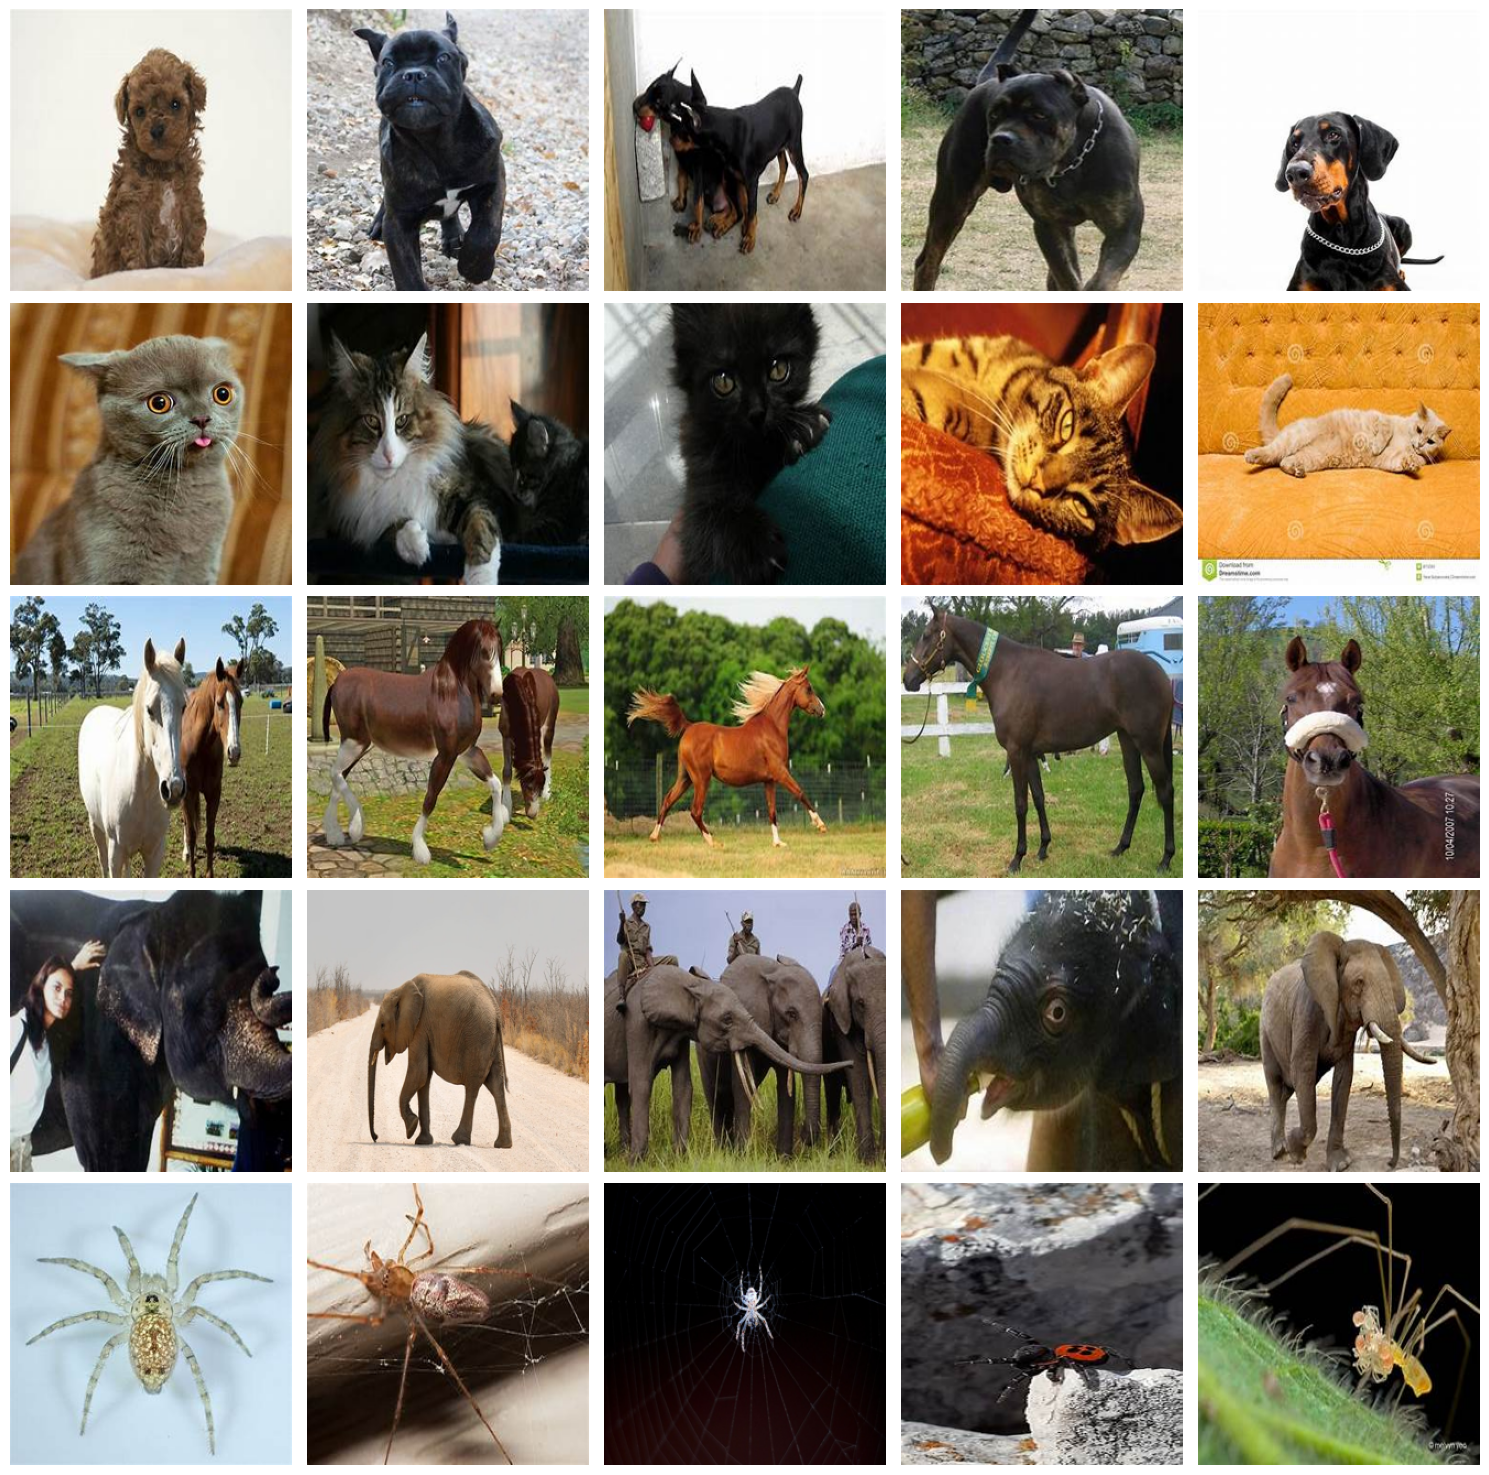

In [14]:
# Define the number of images per class to display
num_images_per_class = 5

# Create a figure for the plot
fig, axes = plt.subplots(len(classes), num_images_per_class, figsize=(15, 15))
fig.tight_layout()

# Iterate over each class
for class_idx, class_name in enumerate(classes):
    # Get the indices of images belonging to the current class
    class_indices = [i for i, label in enumerate(data.labels) if label == data.classEncoding[class_name]]
    
    # Randomly select images from the current class
    selected_indices = random.sample(class_indices, num_images_per_class)
    
    # Plot the selected images
    for img_idx, idx in enumerate(selected_indices):
        img, label = data[idx]
        img = img.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format for plotting
        axes[class_idx, img_idx].imshow(img)
        axes[class_idx, img_idx].axis('off')


plt.tight_layout()
plt.show()

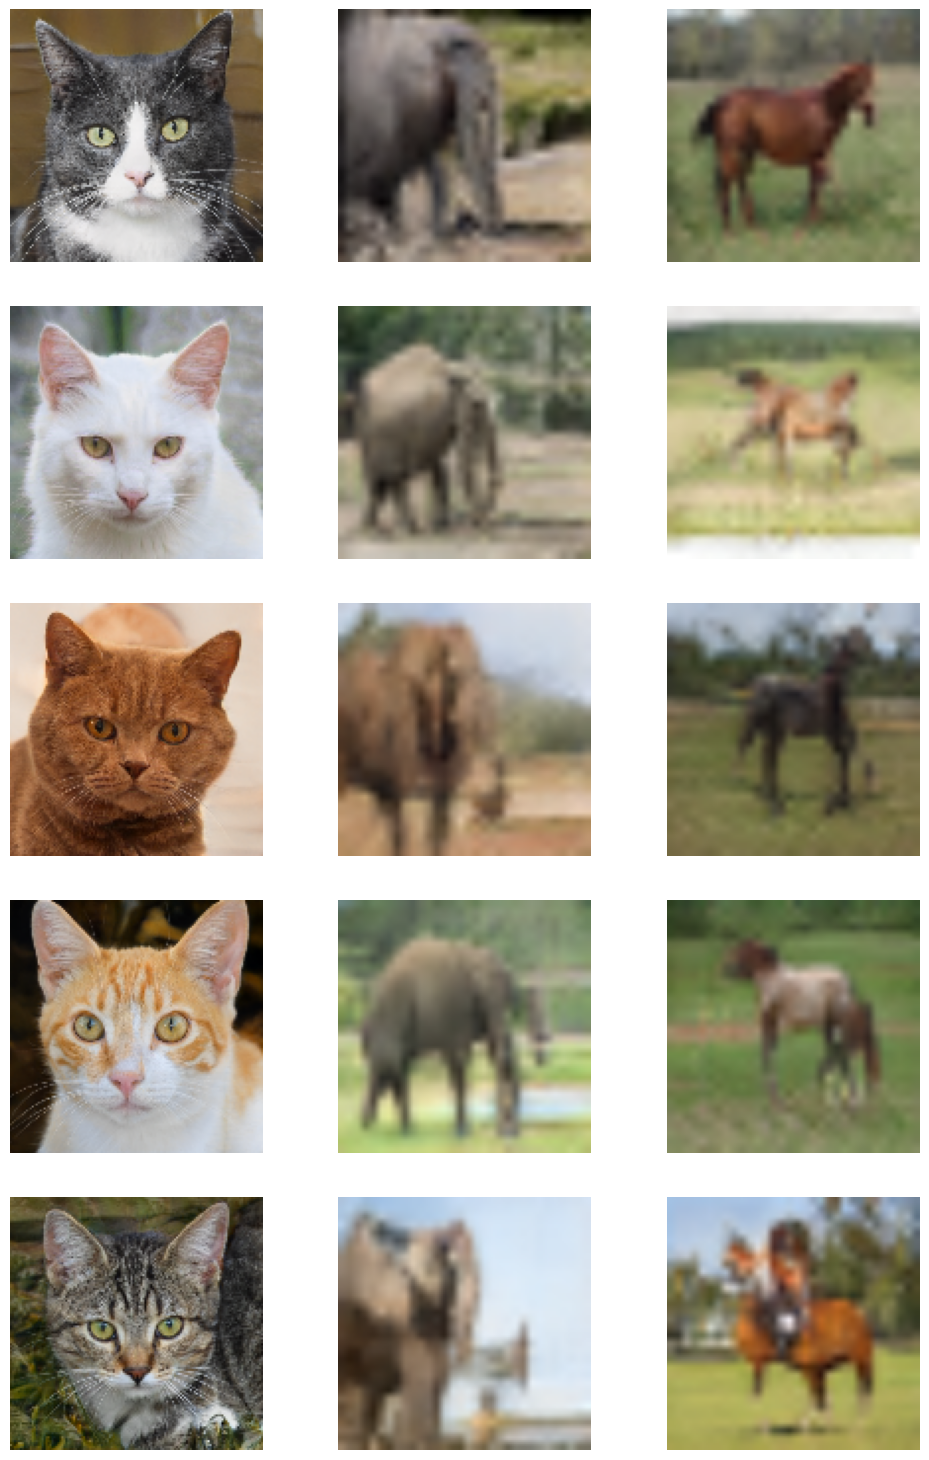

In [39]:
# Define the subdirectories and the number of images per class to display
path = 'Project/data'
subdirectories = ['generated_cats', 'generated_elephants', 'generated_horses']
num_images_per_class = 5

# Create a figure for the plot
fig, axes = plt.subplots( num_images_per_class, len(subdirectories), figsize=(10, 15))
fig.tight_layout()

# Define the transform to resize images to 128x128
resize_transform = A.Compose([
    A.Resize(128, 128),
    ToTensorV2()
])

# Apply the transform to the images
for subdir_idx, subdir in enumerate(subdirectories):
    # Get the list of image files in the current subdirectory
    image_files = os.listdir(os.path.join(path, subdir))
    
    # Randomly select images from the current subdirectory
    selected_images = random.sample(image_files, num_images_per_class)
    
    # Plot the selected images
    for img_idx, img_file in enumerate(selected_images):
        img_path = os.path.join(path, subdir, img_file)
        img = Image.open(img_path)
        img = np.array(img)
        img = resize_transform(image=img)['image']
        img = img.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format for plotting
        axes[img_idx, subdir_idx].imshow(img)
        axes[img_idx, subdir_idx].axis('off')


plt.show()

##### Dataset Loader #####

In [6]:
# Parameters
batch_size = 32

trainingDataLoader = DataLoader(trainingData, batch_size=32, shuffle=True)

### Set up Networks ###

In [7]:
def SelectDevice():
    if torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')
    return device

def TestGenerator(G):
    # Test the generator
    z = torch.randn(1, G.z_dim, device=device)  # Generate a random latent vector
    label = torch.zeros([1, G.c_dim], device=device)  # Generate a dummy label
    img = G(z, label, truncation_psi=0.5, noise_mode='const')  # Generate an image
    img = (img * 127.5 + 128).clamp(0, 255).to(torch.uint8)  # Convert to uint8
    img = img.permute(0, 2, 3, 1)  # Rearrange dimensions to HWC

    # Display the generated image
    plt.imshow(img[0].cpu().numpy())
    plt.axis('off')
    plt.show()

def TestDiscriminator(D):
    img = torch.randn(1, 3, 256, 256, device=device)
    label = torch.tensor([0], device=device)
    result = D(img, label)
    print(f"Generated image p = {result.item():.2f}" if result.item() < 0 else f"Real image p = {result.item():.2f}")
    

network_pkl = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res256-mirror-paper256-noaug.pkl'
device = SelectDevice()


##### Generator #####

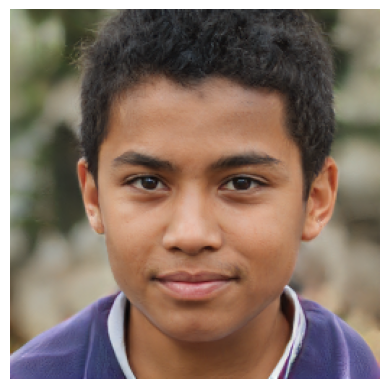

Generator architecture:
Generator(
  (synthesis): SynthesisNetwork(
    (b4): SynthesisBlock(
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConnectedLayer()
      )
    )
    (b8): SynthesisBlock(
      (conv0): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConnectedLayer()
      )
    )
    (b16): SynthesisBlock(
      (conv0): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConnectedLayer()
      )
    )
    (b32): SynthesisBlock(
      (conv0): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
   

In [8]:
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device)  # Generator

TestGenerator(G)
print('Generator architecture:')
print(G)

##### Discriminator #####

In [9]:
with dnnlib.util.open_url(network_pkl) as f:
    D = legacy.load_network_pkl(f)['D'].to(device)  # Discriminator

TestDiscriminator(D)
print('Discriminator architecture:')
print(D)

Generated image p = -1.30
Discriminator architecture:
Discriminator(
  (b256): DiscriminatorBlock(
    (fromrgb): Conv2dLayer()
    (conv0): Conv2dLayer()
    (conv1): Conv2dLayer()
    (skip): Conv2dLayer()
  )
  (b128): DiscriminatorBlock(
    (conv0): Conv2dLayer()
    (conv1): Conv2dLayer()
    (skip): Conv2dLayer()
  )
  (b64): DiscriminatorBlock(
    (conv0): Conv2dLayer()
    (conv1): Conv2dLayer()
    (skip): Conv2dLayer()
  )
  (b32): DiscriminatorBlock(
    (conv0): Conv2dLayer()
    (conv1): Conv2dLayer()
    (skip): Conv2dLayer()
  )
  (b16): DiscriminatorBlock(
    (conv0): Conv2dLayer()
    (conv1): Conv2dLayer()
    (skip): Conv2dLayer()
  )
  (b8): DiscriminatorBlock(
    (conv0): Conv2dLayer()
    (conv1): Conv2dLayer()
    (skip): Conv2dLayer()
  )
  (b4): DiscriminatorEpilogue(
    (mbstd): MinibatchStdLayer()
    (conv): Conv2dLayer()
    (fc): FullyConnectedLayer()
    (out): FullyConnectedLayer()
  )
)


### Training Architecture ###

In [35]:
# Generator parameters
lr_G = 0.0001  # Fine-tuning learning rate
betas_G = (0.0, 0.99)  # Recommended for StyleGAN2-ADA
optimizer_G = torch.optim.Adam(G.parameters(), lr=lr_G, betas=betas_G)

# Discriminator parameters
lr_D = 0.0001  # Fine-tuning learning rate
betas_D = (0.0, 0.99)  # Recommended for StyleGAN2-ADA
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr_D, betas=betas_D)

# General parameters
num_epochs = 25  # Increased for fine-tuning
r1_gamma = 10.0  # Regularization strength for R1

# Loss functions
def generator_loss(fake_pred):
    # Non-saturating GAN loss for the generator
    return torch.nn.functional.softplus(-fake_pred).mean()

def discriminator_loss(real_pred, fake_pred, real_img):
    r1_gamma = 10.0  # Regularization strength for R1
    loss = torch.nn.functional.softplus(fake_pred).mean() + torch.nn.functional.softplus(-real_pred).mean()

    # Ensure that real_img is float32 and requires gradients
    real_img = real_img.float()
    real_img.requires_grad_(True)  # Set requires_grad before passing it to the discriminator

    # Sum real_pred to make it scalar for gradient computation
    real_pred_sum = real_pred.sum()  # Ensure the output is scalar
    
    # Compute gradients for the R1 regularization
    real_pred_grad = torch.autograd.grad(outputs=real_pred_sum, inputs=real_img, create_graph=True, allow_unused=True)[0]
    print(type(real_pred_grad), real_pred_grad)

    # Compute R1 penalty
    r1_penalty = (real_pred_grad.view(real_img.size(0), -1).norm(2, dim=1) ** 2).mean()

    return loss + r1_penalty * (r1_gamma / 2)

In [36]:
for epoch in range(num_epochs):
    for i, data in enumerate(trainingDataLoader):
        # Extract the images and labels from the tuple
        real_images = data[0]['image'].to(device)  # Images are in data[0]['image']
        labels = data[1].to(device)  # Labels are in data[1]

        batch_size = real_images.size(0)

        # Train Discriminator
        optimizer_D.zero_grad()

        # Real images
        real_pred = D(real_images, labels).requires_grad_(True)

        # Generate fake images
        z = torch.randn(batch_size, G.z_dim, device=device)
        fake_labels = torch.zeros(batch_size, 1, requires_grad=True).to(device)
        fake_images = G(z, fake_labels)

        # Fake images
        fake_pred = D(fake_images.detach(), fake_labels)

        # Compute Discriminator Loss (Real + Fake + R1 penalty)
        d_loss = discriminator_loss(real_pred, fake_pred, real_images)
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        # Generate fake images again
        fake_images = G(z, fake_labels)
        fake_pred = D(fake_images)

        # Compute Generator Loss (Non-saturating GAN loss)
        g_loss = generator_loss(fake_pred)
        g_loss.backward()
        optimizer_G.step()

        # Logging progress
        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainingDataLoader)}], '
                  f'D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}, '
                  f'Real Score: {real_pred.mean().item():.4f}, Fake Score: {fake_pred.mean().item():.4f}')

<class 'NoneType'> None


AttributeError: 'NoneType' object has no attribute 'view'

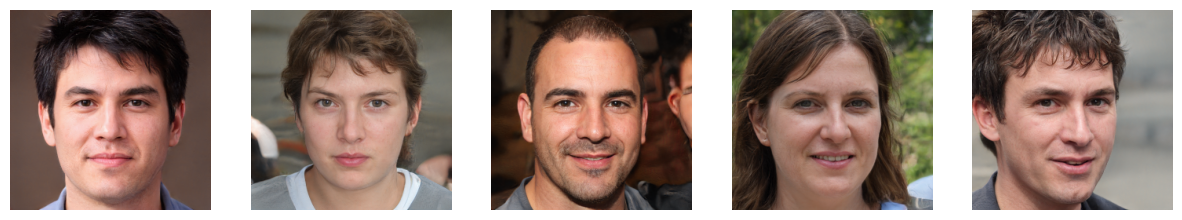

In [18]:
# Number of images to generate
num_images = 5

# Generate random latent vectors
z = torch.randn(num_images, G.z_dim, device=device)

# Generate images
with torch.no_grad():
    G.eval()  # Set the generator to evaluation mode
    generated_images = G(z, None, truncation_psi=0.5, noise_mode='const')
    generated_images = (generated_images * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    generated_images = generated_images.permute(0, 2, 3, 1).cpu().numpy()  # Convert to HWC format

# Plot the generated images
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
for i in range(num_images):
    axes[i].imshow(generated_images[i])
    axes[i].axis('off')
plt.show()

In [38]:
# Loss functions
def generator_loss(fake_pred):
    # Non-saturating GAN loss for the generator
    return torch.nn.functional.softplus(-fake_pred).mean()

def discriminator_loss(real_pred, fake_pred, real_img):
    r1_gamma = 10.0  # Regularization strength for R1
    loss = torch.nn.functional.softplus(fake_pred).mean() + torch.nn.functional.softplus(-real_pred).mean()

    # Ensure that real_img is float32 and requires gradients
    real_img = real_img.float()
    real_img.requires_grad_(True)  # Set requires_grad before passing it to the discriminator

    # Sum real_pred to make it scalar for gradient computation
    real_pred_sum = real_pred.sum()  # Ensure the output is scalar
    
    # Compute gradients for the R1 regularization
    real_pred_grad = torch.autograd.grad(outputs=real_pred_sum, inputs=real_img, create_graph=True, allow_unused=True)[0]
    print(type(real_pred_grad), real_pred_grad)

    # Compute R1 penalty
    r1_penalty = (real_pred_grad.view(real_img.size(0), -1).norm(2, dim=1) ** 2).mean()

    return loss + r1_penalty * (r1_gamma / 2)

In [39]:
# Training loop for fine-tuning StyleGAN2 on your dataset

# Function to save the model checkpoints
def save_checkpoint(epoch, G, D, optimizer_G, optimizer_D, checkpoint_path):
    torch.save({
        'epoch': epoch,
        'G_state_dict': G.state_dict(),
        'D_state_dict': D.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
    }, checkpoint_path)

# Training loop
for epoch in range(num_epochs):
    G.train()
    D.train()
    for i, data in enumerate(trainingDataLoader):
        # Extract the images and labels from the tuple
        real_images = data[0]['image'].to(device)  # Images are in data[0]['image']
        labels = data[1].to(device)  # Labels are in data[1]

        batch_size = real_images.size(0)

        # Train Discriminator
        optimizer_D.zero_grad()

        # Real images
        real_pred = D(real_images, labels).requires_grad_(True)

        # Generate fake images
        z = torch.randn(batch_size, G.z_dim, device=device)
        fake_labels = torch.zeros(batch_size, 1, requires_grad=True).to(device)
        fake_images = G(z, fake_labels)

        # Fake images
        fake_pred = D(fake_images.detach(), fake_labels)

        # Compute Discriminator Loss (Real + Fake + R1 penalty)
        d_loss = discriminator_loss(real_pred, fake_pred, real_images)
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        # Generate fake images again
        fake_images = G(z, fake_labels)
        fake_pred = D(fake_images)

        # Compute Generator Loss (Non-saturating GAN loss)
        g_loss = generator_loss(fake_pred)
        g_loss.backward()
        optimizer_G.step()

        # Logging progress
        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainingDataLoader)}], '
                  f'D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}, '
                  f'Real Score: {real_pred.mean().item():.4f}, Fake Score: {fake_pred.mean().item():.4f}')

    # Save checkpoint after each epoch
    save_checkpoint(epoch, G, D, optimizer_G, optimizer_D, f'checkpoint_epoch_{epoch+1}.pth')

<class 'NoneType'> None


AttributeError: 'NoneType' object has no attribute 'view'

In [4]:
from tqdm import tqdm
import os
from PIL import Image
def ensure_rgb_and_png(directory):
    for filename in tqdm(os.listdir(directory)):
        file_path = os.path.join(directory, filename)
        image = Image.open(file_path)
        
        # Convert to RGB if not already
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        # Save as .png
        new_filename = os.path.splitext(filename)[0] + '.png'
        new_file_path = os.path.join(directory, new_filename)
        image.save(new_file_path, 'PNG')
        
        # Remove the old file if the format was changed
        if new_file_path != file_path:
            os.remove(file_path)

# Directories
validation_dir = 'Project/data/Validation'
test_dir = 'Project/data/Test'

# Ensure all images in validation and test directories are RGB and .png format
ensure_rgb_and_png(validation_dir)
ensure_rgb_and_png(test_dir)

  0%|          | 0/2368 [00:00<?, ?it/s]

100%|██████████| 2500/2500 [01:12<00:00, 34.29it/s]


### Classifier ###